<a href="https://colab.research.google.com/github/lorenzo-stacchio/NLP_Lecture/blob/main/NLP_Fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing Fundamentals

In [3]:
! pip install kagglehub[pandas-datasets] wordcloud matplotlib numpy pillow

## Imports

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from scipy.spatial.distance import cdist
import pandas as pd
import seaborn as sns

We need to import several things from Keras.

## Load Data

We will use a data-set consisting of 50000 reviews of movies from IMDB. Keras has a built-in function for downloading a similar data-set (but apparently half the size). However, Keras' version has already converted the text in the data-set to integer-tokens, which is a crucial part of working with natural languages that will also be demonstrated in this tutorial, so we download the actual text-data.

NOTE: The data-set is 84 MB and will be downloaded automatically.

In [5]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "IMDB Dataset.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "lakshmi25npathi/imdb-dataset-of-50k-movie-reviews",
  file_path,
)

print("First 5 records:", df.head())

<ipython-input-5-15f2824f6c2d>:8: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


First 5 records:                                               review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [6]:
print("Dataset Samples:", len(df))

Dataset Samples: 50000


## Data Visualization

<Axes: xlabel='sentiment', ylabel='Count'>

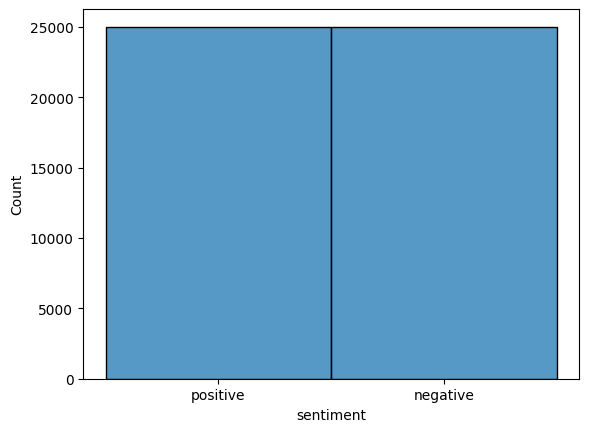

In [7]:
## We could visualize how many sentiment!
sns.histplot(df, x = "sentiment")

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_cloud(text):
  # Create a WordCloud object
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
  # Display the generated image
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

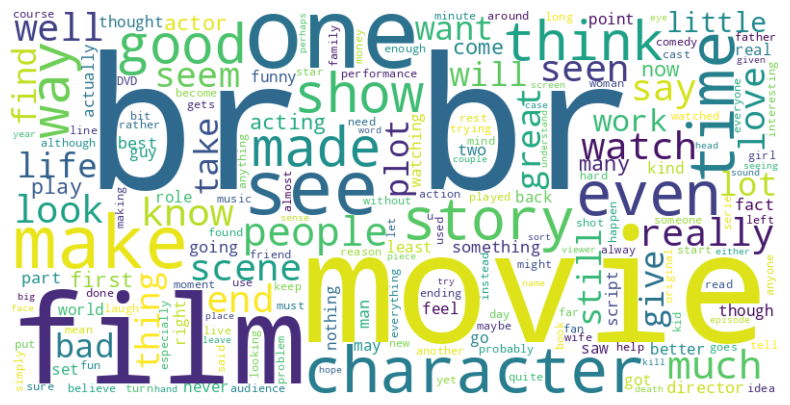

In [20]:
## ACCUMULATE ALL THE TEXT
total_text = df['review'].str.cat(sep=' ')
generate_word_cloud(total_text)

<h1> Vedete un problema? </h1>


## DataSet Preparation

Load the training- and test-sets.

In [34]:
from sklearn.model_selection import train_test_split

# Assuming 'df' has a column 'review' for the text and 'sentiment' for the label
X = df['review']       # Features (text)
y = df['sentiment']    # Labels (positive/negative)


# Split the dataset into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 20% for testing
    random_state=42,    # Ensures reproducibility
    stratify=y          # Keeps class distribution balanced
)

In [35]:
print("Training samples:", len(y_train))
print("Testing samples:", len(y_test))

Training samples: 40000
Testing samples: 10000


## Spacy as an all-in-one text processing library

In [24]:
import spacy
import tqdm

# Preprocessing function
def preprocess(texts):
    cleaned_texts = []
    # Disables named entity recognition (ner) and syntactic parsing (parser) since we don’t need them—this speeds things up.
    for doc in tqdm.tqdm(nlp.pipe(texts, disable=["ner", "parser"]), total = len(texts)):
        tokens = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]
        ## DEBUG
        # print(doc, "\n", tokens)
        # break
        cleaned_texts.append(" ".join(tokens))
    return cleaned_texts

In [ ]:
# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

In [ ]:
limit = -1 ## use -1 if you want to use them all, otherwise use an index inferior to the maximum (example 5000)

train_cleaned = preprocess(X_train[:limit])
test_cleaned = preprocess(X_test[:limit])

## INDEX ALSO LABELS TO HAVE SAME SAMPLES FOR MODEL TRAINING
y_train  =  y_train[:limit]
y_test = y_test[:limit]

 40%|███▉      | 15869/39999 [06:33<03:33, 113.25it/s]

## VISUALIZZIAMO ANCORA WORD CLOUD


In [ ]:
generate_word_cloud(" ".join(train_cleaned))

# CONVERT TOKENS INTO VECTORS!

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(train_cleaned)
X_test = vectorizer.transform(test_cleaned)

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


ValueError: Found input variables with inconsistent numbers of samples: [100, 40000]

## Padding and Truncating Data

The Recurrent Neural Network can take sequences of arbitrary length as input, but in order to use a whole batch of data, the sequences need to have the same length. There are two ways of achieving this: (A) Either we ensure that all sequences in the entire data-set have the same length, or (B) we write a custom data-generator that ensures the sequences have the same length within each batch.

Solution (A) is simpler but if we use the length of the longest sequence in the data-set, then we are wasting a lot of memory. This is particularly important for larger data-sets.

So in order to make a compromise, we will use a sequence-length that covers most sequences in the data-set, and we will then truncate longer sequences and pad shorter sequences.

First we count the number of tokens in all the sequences in the data-set.

In [ ]:
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)

The average number of tokens in a sequence is:

In [ ]:
np.mean(num_tokens)

The maximum number of tokens in a sequence is:

In [ ]:
np.max(num_tokens)

The max number of tokens we will allow is set to the average plus 2 standard deviations.

In [ ]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

This covers about 95% of the data-set.

In [ ]:
np.sum(num_tokens < max_tokens) / len(num_tokens)

When padding or truncating the sequences that have a different length, we need to determine if we want to do this padding or truncating 'pre' or 'post'. If a sequence is truncated, it means that a part of the sequence is simply thrown away. If a sequence is padded, it means that zeros are added to the sequence.

So the choice of 'pre' or 'post' can be important because it determines whether we throw away the first or last part of a sequence when truncating, and it determines whether we add zeros to the beginning or end of the sequence when padding. This may confuse the Recurrent Neural Network.

In [ ]:
pad = 'pre'

In [ ]:
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens,
                            padding=pad, truncating=pad)

In [ ]:
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)

We have now transformed the training-set into one big matrix of integers (tokens) with this shape:

In [ ]:
x_train_pad.shape

The matrix for the test-set has the same shape:

In [ ]:
x_test_pad.shape

For example, we had the following sequence of tokens above:

In [ ]:
np.array(x_train_tokens[1])

This has simply been padded to create the following sequence. Note that when this is input to the Recurrent Neural Network, then it first inputs a lot of zeros. If we had padded 'post' then it would input the integer-tokens first and then a lot of zeros. This may confuse the Recurrent Neural Network.

In [ ]:
x_train_pad[1]

## Tokenizer Inverse Map

For some strange reason, the Keras implementation of a tokenizer does not seem to have the inverse mapping from integer-tokens back to words, which is needed to reconstruct text-strings from lists of tokens. So we make that mapping here.

In [ ]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

Helper-function for converting a list of tokens back to a string of words.

In [ ]:
def tokens_to_string(tokens):
    # Map from tokens back to words.
    words = [inverse_map[token] for token in tokens if token != 0]

    # Concatenate all words.
    text = " ".join(words)

    return text

For example, this is the original text from the data-set:

In [ ]:
x_train_text[1]

We can recreate this text except for punctuation and other symbols, by converting the list of tokens back to words:

In [ ]:
tokens_to_string(x_train_tokens[1])

## Create the Recurrent Neural Network

We are now ready to create the Recurrent Neural Network (RNN). We will use the Keras API for this because of its simplicity. See Tutorial #03-C for a tutorial on Keras.

In [ ]:
model = Sequential()

The first layer in the RNN is a so-called Embedding-layer which converts each integer-token into a vector of values. This is necessary because the integer-tokens may take on values between 0 and 10000 for a vocabulary of 10000 words. The RNN cannot work on values in such a wide range. The embedding-layer is trained as a part of the RNN and will learn to map words with similar semantic meanings to similar embedding-vectors, as will be shown further below.

First we define the size of the embedding-vector for each integer-token. In this case we have set it to 8, so that each integer-token will be converted to a vector of length 8. The values of the embedding-vector will generally fall roughly between -1.0 and 1.0, although they may exceed these values somewhat.

The size of the embedding-vector is typically selected between 100-300, but it seems to work reasonably well with small values for Sentiment Analysis.

In [ ]:
embedding_size = 8

The embedding-layer also needs to know the number of words in the vocabulary (`num_words`) and the length of the padded token-sequences (`max_tokens`). We also give this layer a name because we need to retrieve its weights further below.

In [ ]:
model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='layer_embedding'))

We can now add the first Gated Recurrent Unit (GRU) to the network. This will have 16 outputs. Because we will add a second GRU after this one, we need to return sequences of data because the next GRU expects sequences as its input.

In [ ]:
model.add(GRU(units=16, return_sequences=True))

This adds the second GRU with 8 output units. This will be followed by another GRU so it must also return sequences.

In [ ]:
model.add(GRU(units=8, return_sequences=True))

This adds the third and final GRU with 4 output units. This will be followed by a dense-layer, so it should only give the final output of the GRU and not a whole sequence of outputs.

In [ ]:
model.add(GRU(units=4))

Add a fully-connected / dense layer which computes a value between 0.0 and 1.0 that will be used as the classification output.

In [ ]:
model.add(Dense(1, activation='sigmoid'))

Use the Adam optimizer with the given learning-rate.

In [ ]:
optimizer = Adam(lr=1e-3)

Compile the Keras model so it is ready for training.

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
model.summary()

## Train the Recurrent Neural Network

We can now train the model. Note that we are using the data-set with the padded sequences. We use 5% of the training-set as a small validation-set, so we have a rough idea whether the model is generalizing well or if it is perhaps over-fitting to the training-set.

In [ ]:
%%time
model.fit(x_train_pad, y_train,
          validation_split=0.05, epochs=3, batch_size=64)

## Performance on Test-Set

Now that the model has been trained we can calculate its classification accuracy on the test-set.

In [ ]:
%%time
result = model.evaluate(x_test_pad, y_test)

In [ ]:
print("Accuracy: {0:.2%}".format(result[1]))

## Example of Mis-Classified Text

In order to show an example of mis-classified text, we first calculate the predicted sentiment for the first 1000 texts in the test-set.

In [ ]:
%%time
y_pred = model.predict(x=x_test_pad[0:1000])
y_pred = y_pred.T[0]

These predicted numbers fall between 0.0 and 1.0. We use a cutoff / threshold and say that all values above 0.5 are taken to be 1.0 and all values below 0.5 are taken to be 0.0. This gives us a predicted "class" of either 0.0 or 1.0.

In [ ]:
cls_pred = np.array([1.0 if p>0.5 else 0.0 for p in y_pred])

The true "class" for the first 1000 texts in the test-set are needed for comparison.

In [ ]:
cls_true = np.array(y_test[0:1000])

We can then get indices for all the texts that were incorrectly classified by comparing all the "classes" of these two arrays.

In [ ]:
incorrect = np.where(cls_pred != cls_true)
incorrect = incorrect[0]

Of the 1000 texts used, how many were mis-classified?

In [ ]:
len(incorrect)

Let us look at the first mis-classified text. We will use its index several times.

In [ ]:
idx = incorrect[0]
idx

The mis-classified text is:

In [ ]:
text = x_test_text[idx]
text

These are the predicted and true classes for the text:

In [ ]:
y_pred[idx]

In [ ]:
cls_true[idx]

## New Data

Let us try and classify new texts that we make up. Some of these are obvious, while others use negation and sarcasm to try and confuse the model into mis-classifying the text.

In [ ]:
text1 = "This movie is fantastic! I really like it because it is so good!"
text2 = "Good movie!"
text3 = "Maybe I like this movie."
text4 = "Meh ..."
text5 = "If I were a drunk teenager then this movie might be good."
text6 = "Bad movie!"
text7 = "Not a good movie!"
text8 = "This movie really sucks! Can I get my money back please?"
texts = [text1, text2, text3, text4, text5, text6, text7, text8]

We first convert these texts to arrays of integer-tokens because that is needed by the model.

In [ ]:
tokens = tokenizer.texts_to_sequences(texts)

To input texts with different lengths into the model, we also need to pad and truncate them.

In [ ]:
tokens_pad = pad_sequences(tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)
tokens_pad.shape

We can now use the trained model to predict the sentiment for these texts.

In [ ]:
model.predict(tokens_pad)

A value close to 0.0 means a negative sentiment and a value close to 1.0 means a positive sentiment. These numbers will vary every time you train the model.

## Embeddings

The model cannot work on integer-tokens directly, because they are integer values that may range between 0 and the number of words in our vocabulary, e.g. 10000. So we need to convert the integer-tokens into vectors of values that are roughly between -1.0 and 1.0 which can be used as input to a neural network.

This mapping from integer-tokens to real-valued vectors is also called an "embedding". It is essentially just a matrix where each row contains the vector-mapping of a single token. This means we can quickly lookup the mapping of each integer-token by simply using the token as an index into the matrix. The embeddings are learned along with the rest of the model during training.

Ideally the embedding would learn a mapping where words that are similar in meaning also have similar embedding-values. Let us investigate if that has happened here.

First we need to get the embedding-layer from the model:

In [ ]:
layer_embedding = model.get_layer('layer_embedding')

We can then get the weights used for the mapping done by the embedding-layer.

In [ ]:
weights_embedding = layer_embedding.get_weights()[0]

Note that the weights are actually just a matrix with the number of words in the vocabulary times the vector length for each embedding. That's because it is basically just a lookup-matrix.

In [ ]:
weights_embedding.shape

Let us get the integer-token for the word 'good', which is just an index into the vocabulary.

In [ ]:
token_good = tokenizer.word_index['good']
token_good

Let us also get the integer-token for the word 'great'.

In [ ]:
token_great = tokenizer.word_index['great']
token_great

These integertokens may be far apart and will depend on the frequency of those words in the data-set.

Now let us compare the vector-embeddings for the words 'good' and 'great'. Several of these values are similar, although some values are quite different. Note that these values will change every time you train the model.

In [ ]:
weights_embedding[token_good]

In [ ]:
weights_embedding[token_great]

Similarly, we can compare the embeddings for the words 'bad' and 'horrible'.

In [ ]:
token_bad = tokenizer.word_index['bad']
token_horrible = tokenizer.word_index['horrible']

In [ ]:
weights_embedding[token_bad]

In [ ]:
weights_embedding[token_horrible]

### Sorted Words

We can also sort all the words in the vocabulary according to their "similarity" in the embedding-space. We want to see if words that have similar embedding-vectors also have similar meanings.

Similarity of embedding-vectors can be measured by different metrics, e.g. Euclidean distance or cosine distance.

We have a helper-function for calculating these distances and printing the words in sorted order.

In [ ]:
def print_sorted_words(word, metric='cosine'):
    """
    Print the words in the vocabulary sorted according to their
    embedding-distance to the given word.
    Different metrics can be used, e.g. 'cosine' or 'euclidean'.
    """

    # Get the token (i.e. integer ID) for the given word.
    token = tokenizer.word_index[word]

    # Get the embedding for the given word. Note that the
    # embedding-weight-matrix is indexed by the word-tokens
    # which are integer IDs.
    embedding = weights_embedding[token]

    # Calculate the distance between the embeddings for
    # this word and all other words in the vocabulary.
    distances = cdist(weights_embedding, [embedding],
                      metric=metric).T[0]

    # Get an index sorted according to the embedding-distances.
    # These are the tokens (integer IDs) for words in the vocabulary.
    sorted_index = np.argsort(distances)

    # Sort the embedding-distances.
    sorted_distances = distances[sorted_index]

    # Sort all the words in the vocabulary according to their
    # embedding-distance. This is a bit excessive because we
    # will only print the top and bottom words.
    sorted_words = [inverse_map[token] for token in sorted_index
                    if token != 0]

    # Helper-function for printing words and embedding-distances.
    def _print_words(words, distances):
        for word, distance in zip(words, distances):
            print("{0:.3f} - {1}".format(distance, word))

    # Number of words to print from the top and bottom of the list.
    k = 10

    print("Distance from '{0}':".format(word))

    # Print the words with smallest embedding-distance.
    _print_words(sorted_words[0:k], sorted_distances[0:k])

    print("...")

    # Print the words with highest embedding-distance.
    _print_words(sorted_words[-k:], sorted_distances[-k:])

We can then print the words that are near and far from the word 'great' in terms of their vector-embeddings. Note that these may change each time you train the model.

In [ ]:
print_sorted_words('great', metric='cosine')

Similarly, we can print the words that are near and far from the word 'worst' in terms of their vector-embeddings.

In [ ]:
print_sorted_words('worst', metric='cosine')

## Conclusion

This tutorial showed the basic methods for doing Natural Language Processing (NLP) using a Recurrent Neural Network with integer-tokens and an embedding layer. This was used to do sentiment analysis of movie reviews from IMDB. It works reasonably well if the hyper-parameters are chosen properly. But it is important to understand that this is not human-like comprehension of text. The system does not have any real understanding of the text. It is just a clever way of doing pattern-recognition.

## Exercises

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook before making any changes.

* Run more training-epochs. Does it improve performance?
* If your model overfits the training-data, try using dropout-layers and dropout inside the GRU.
* Increase or decrease the number of words in the vocabulary. This is done when the `Tokenizer` is initialized. Does it affect performance?
* Increase the size of the embedding-vectors to e.g. 200. Does it affect performance?
* Try varying all the different hyper-parameters for the Recurrent Neural Network.
* Use Bayesian Optimization from Tutorial #19 to find the best choice of hyper-parameters.
* Use 'post' for padding and truncating in `pad_sequences()`. Does it affect the performance?
* Use individual characters instead of tokenized words as the vocabulary. You can then use one-hot encoded vectors for each character instead of using the embedding-layer.
* Use `model.fit_generator()` instead of `model.fit()` and make your own data-generator, which creates a batch of data using a random subset of `x_train_tokens`. The sequences must be padded so they all match the length of the longest sequence.
* Explain to a friend how the program works.

## License (MIT)

Copyright (c) 2018 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.